In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import tarfile
import scipy.io as sio
import numpy as np
import os
import cv2 as cv
import shutil
import random
from pathlib import Path
import pandas as pd

In [ ]:
pwd

In [8]:
from utils import get_path, get_x, get_y, show_img, draw_outline, draw_rect, draw_text, crop, compare_top_losses, compare_most_confused

In [9]:
path = get_path();path

Path('C:/Users/Morningstar/Documents/CARSv2')

In [5]:
list(path.iterdir())

[WindowsPath('C:/Users/Morningstar/Documents/CARSv2/.ipynb_checkpoints'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/1-CarsBaseline.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/2-CarsBaseline-ImgScaling.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/3-Cars-ImgScaling-LrRatesTuning.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasic.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasicv2-BasicResNet50.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasicv2-TRES.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasicv2.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_annos.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_meta.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_test_annos.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_test_annos_withlabels.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_trai

In [4]:
cars_test = Path(path/'test')
cars_train = Path(path/'train')

In [6]:
len(list(cars_test.iterdir()))
len(list(cars_train.iterdir()))

8144

# Ucitavanje i kreiranje DataBlock i DataLoaders objekta

In [10]:
from fastai.vision.all import *
from fastai.metrics import error_rate
from fastai import *
import cv2 as cv
import numpy as np
import pandas as pd
import scipy.io as sio
from PIL import Image
import timm
from wwf.vision.timm import *
import torch
import torchvision
import random
from torch.distributions.beta import Beta

In [11]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

Ucitavanje pandas dataframe-ova

In [12]:
labels_df = pd.read_csv(path/'labels_with_annos.csv')
train_labels_df = pd.read_csv(path/'train_labels_with_annos.csv')
test_labels_df = pd.read_csv(path/'test_labels_with_annos.csv')

In [11]:
labels_df.head(10)

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,class_name,is_test,filename_cropped,bbox_h,bbox_w
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,0,cropped_00001.jpg,260,531
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,0,cropped_00002.jpg,472,833
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,0,cropped_00003.jpg,273,517
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,0,cropped_00004.jpg,704,864
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,0,cropped_00005.jpg,64,120
5,00006.jpg,259,289,515,416,123,Geo Metro Convertible 1993,0,cropped_00006.jpg,128,257
6,00007.jpg,88,80,541,397,89,Dodge Journey SUV 2012,0,cropped_00007.jpg,318,454
7,00008.jpg,73,79,591,410,96,Dodge Charger Sedan 2012,0,cropped_00008.jpg,332,519
8,00009.jpg,20,126,1269,771,167,Mitsubishi Lancer Sedan 2012,0,cropped_00009.jpg,646,1250
9,00010.jpg,21,110,623,367,58,Chevrolet Traverse SUV 2012,0,cropped_00010.jpg,258,603


In [12]:
train_labels_df.head(10)

,filename,class_name,class_id
0,00001.jpg,Audi TTS Coupe 2012,14
1,00002.jpg,Acura TL Sedan 2012,3
2,00003.jpg,Dodge Dakota Club Cab 2007,91
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,134
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,106
5,00006.jpg,Geo Metro Convertible 1993,123
6,00007.jpg,Dodge Journey SUV 2012,89
7,00008.jpg,Dodge Charger Sedan 2012,96
8,00009.jpg,Mitsubishi Lancer Sedan 2012,167
9,00010.jpg,Chevrolet Traverse SUV 2012,58


In [13]:
test_labels_df.head(10)

,filename,class_name,class_id,vocab_id
0,test_00001.jpg,Suzuki Aerio Sedan 2007,181,180
1,test_00002.jpg,Ferrari 458 Italia Convertible 2012,103,100
2,test_00003.jpg,Jeep Patriot SUV 2012,145,147
3,test_00004.jpg,Toyota Camry Sedan 2012,187,186
4,test_00005.jpg,Tesla Model S Sedan 2012,185,184
5,test_00006.jpg,Chrysler Town and Country Minivan 2012,78,80
6,test_00007.jpg,GMC Terrain SUV 2012,118,120
7,test_00008.jpg,Mercedes-Benz S-Class Sedan 2012,165,163
8,test_00009.jpg,BMW X5 SUV 2007,32,35
9,test_00010.jpg,Chevrolet HHR SS 2010,60,61


Funkcija za dobavljanje dataloaders objekta na osnovu velicine slike, batch size i seed parametra. 

In [18]:
def get_dls(size,bs,seed):
    random_seed(seed,True)
    augs = [*aug_transforms(size=size),Normalize.from_stats(*imagenet_stats),ToTensor()]
    
    dblock= DataBlock((ImageBlock, CategoryBlock),
                  splitter=RandomSplitter(seed=seed),
                  get_x=get_x, 
                  get_y=get_y,
                  item_tfms=[Resize(299, method='squish'),ToTensor()],
                  batch_tfms=augs)
    dls = dblock.dataloaders(train_labels_df, bs=bs, num_workers=0)
    return dls

# Label smoothing + MixUp + Img Scaling

U ovoj varijanti cemo kombinirati label smoothing loss funkciju sa MixUp regularizacijom i velikim brojem trening epoha da bi ove dvije metode imali sto bolji efekat. Uz to dodat cemo i skaliranje slika.

## Size 192 Stage1

In [23]:
size = 192
bs = 96
seed = 42
dls = get_dls(size, bs, seed)

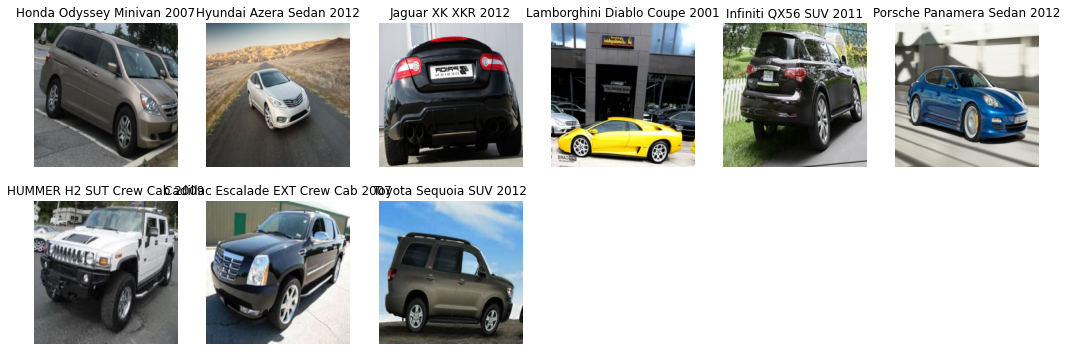

In [10]:
dls.show_batch(nrows=2, ncols=6)

## Kreiranje modela

Kreiramo model koristeci ResNet50 arhitekturu sa Label Smoothing loss funkcijom i Mixup regularizacijom.
Kao optimizator se koristi Adam, a u jednoj od slijedecih varijanti cemo primjeniti drugi optimizator koji je specificno dobar u kombinaciji sa Label Smoothing i Mixupom i velikim brojem epoha u treningu

Kao metrika po kojoj cemo pratiti trening koristimo preciznost(accuracy).

Dio to_fp16() definira mixed precision trening koji ubrzava trening na određenim grafickim karticama kao sto je moja RTX 2060 Super.

In [24]:
learn = cnn_learner(dls, resnet50, metrics=accuracy, cbs=MixUp, loss_func= LabelSmoothingCrossEntropy()).to_fp16()

Nakon kreiranja modela mozemo krenuti sa treningom.

## Treniranje modela

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.013182567432522774)

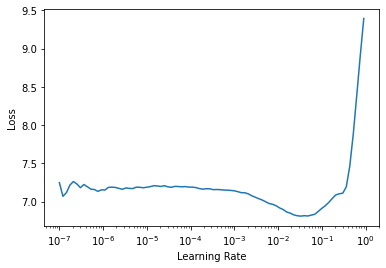

In [21]:
learn.lr_find()

In [25]:
learn.fine_tune(16,max_lr=1e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,6.870886,5.130739,0.052211,03:42
1,5.963225,4.238934,0.176904,03:37
2,5.218962,3.811283,0.245700,03:40
3,4.670150,3.511683,0.293612,03:37


epoch,train_loss,valid_loss,accuracy,time
0,3.934184,3.127009,0.378993,03:40
1,3.720191,2.857012,0.440418,03:46
2,3.523593,2.660741,0.509828,03:40
3,3.357401,2.493672,0.538698,03:37
4,3.162026,2.362304,0.562654,03:35
5,3.007076,2.202496,0.636978,03:35
6,2.823245,2.061704,0.662162,03:40
7,2.715382,2.005621,0.690418,03:39
8,2.619903,1.936408,0.713145,03:34
9,2.534436,1.883776,0.730958,03:32


In [26]:
learn.save('stage1-resnet50-mixuplabelsmooth-imgscale-192px')

Path('models/stage1-resnet50-mixuplabelsmooth-imgscale-192px.pth')

In [27]:
learn.load('stage1-resnet50-mixuplabelsmooth-imgscale-192px')

## Stage 2 size 256

In [28]:
size = 256
bs = 64
seed = 42
dls = get_dls(size, bs, seed)

In [29]:
learn.dls = dls

In [30]:
learn.fine_tune(16,max_lr=1e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,2.323085,1.705231,0.792383,03:41
1,2.315064,1.707948,0.783784,03:41
2,2.377791,1.739982,0.779484,03:39
3,2.414945,1.728482,0.778870,03:41


epoch,train_loss,valid_loss,accuracy,time
0,2.310007,1.663226,0.802211,03:50
1,2.279872,1.654137,0.799754,03:50
2,2.278249,1.675838,0.792998,03:49
3,2.326073,1.707323,0.789312,03:48
4,2.308534,1.675561,0.791155,03:48
5,2.286261,1.652359,0.799754,03:49
6,2.240029,1.621460,0.812654,03:48
7,2.205545,1.591599,0.818182,03:49
8,2.155024,1.558091,0.828010,03:49
9,2.118182,1.531531,0.840295,03:49


In [31]:
learn.save('stage2-resnet50-mixuplabelsmooth-imgscale-256px')

Path('models/stage2-resnet50-mixuplabelsmooth-imgscale-256px.pth')

In [32]:
learn.load('stage2-resnet50-mixuplabelsmooth-imgscale-256px')

## Stage 3 Size 299

In [33]:
size = 299
bs = 64
seed = 42
dls = get_dls(size, bs, seed)

In [34]:
learn.dls = dls

In [35]:
learn.fine_tune(16,max_lr=1e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.973935,1.503077,0.859337,03:51
1,1.917747,1.516812,0.859337,03:50
2,1.888693,1.582474,0.838452,03:49
3,1.914567,1.580553,0.842138,03:48


epoch,train_loss,valid_loss,accuracy,time
0,1.999587,1.504685,0.861794,04:00
1,1.950512,1.529990,0.850737,04:01
2,1.910325,1.545766,0.843366,04:01
3,1.919149,1.622908,0.829853,04:01
4,1.909158,1.612296,0.836609,04:01
5,1.908223,1.629311,0.834152,04:00
6,1.902794,1.580052,0.834152,04:01
7,1.896958,1.567148,0.828624,04:02
8,1.875083,1.540174,0.851351,04:01
9,1.876866,1.497008,0.855651,04:02


In [36]:
learn.save('stage3-resnet50-mixuplabelsmooth-imgscale-299px')

Path('models/stage3-resnet50-mixuplabelsmooth-imgscale-299px.pth')

In [37]:
learn.load('stage3-resnet50-mixuplabelsmooth-imgscale-299px')

# Rezulatati

In [39]:
interp = ClassificationInterpretation.from_learner(learn)

PREDICTION:Acura RL Sedan 2012, ACTUAL:Acura TSX Sedan 2012
Loss: 6.58, Probability: -0.0907


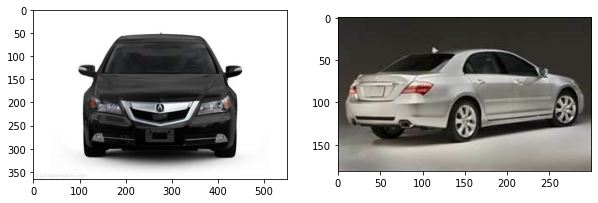

PREDICTION:Dodge Caravan Minivan 1997, ACTUAL:BMW 3 Series Wagon 2012
Loss: 6.06, Probability: 1.5254


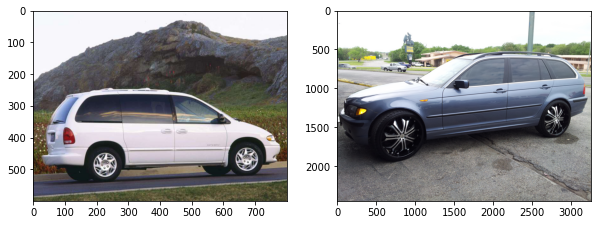

PREDICTION:Porsche Panamera Sedan 2012, ACTUAL:Mitsubishi Lancer Sedan 2012
Loss: 6.02, Probability: 2.5664


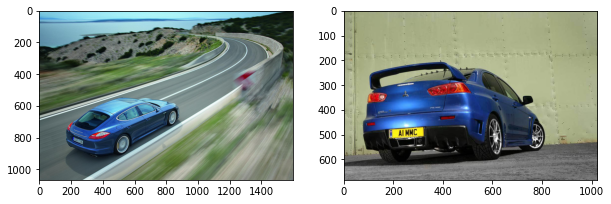

PREDICTION:Spyker C8 Convertible 2009, ACTUAL:Nissan Juke Hatchback 2012
Loss: 5.86, Probability: 2.6562


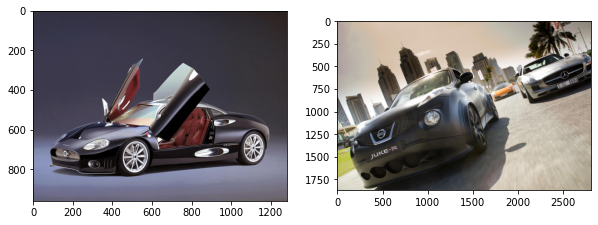

PREDICTION:Chevrolet Express Cargo Van 2007, ACTUAL:GMC Savana Van 2012
Loss: 5.84, Probability: 0.9565


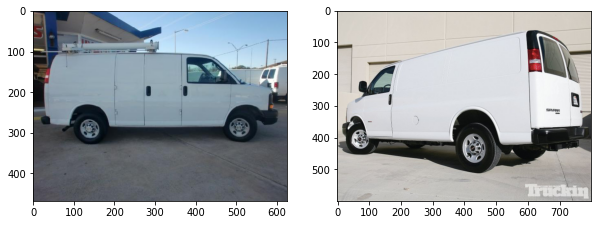

PREDICTION:Geo Metro Convertible 1993, ACTUAL:Aston Martin V8 Vantage Convertible 2012
Loss: 5.81, Probability: 1.3818


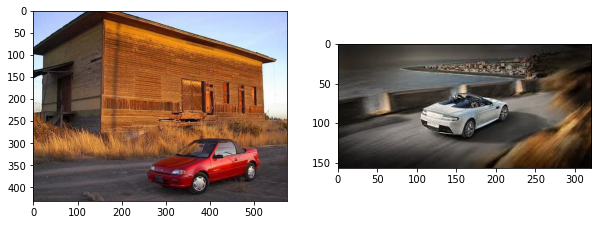

PREDICTION:Bentley Continental Supersports Conv. Convertible 2012, ACTUAL:Chevrolet Monte Carlo Coupe 2007
Loss: 5.73, Probability: 1.0381


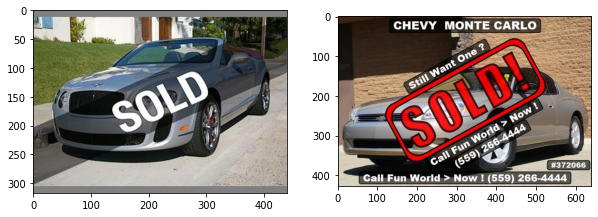

PREDICTION:Hyundai Veracruz SUV 2012, ACTUAL:Nissan Juke Hatchback 2012
Loss: 5.50, Probability: -1.1611


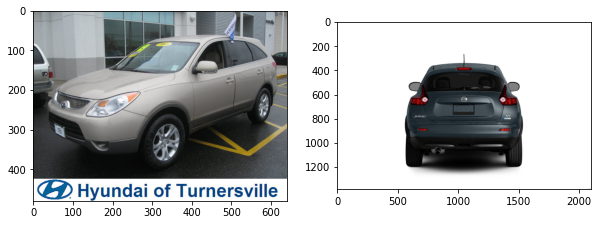

PREDICTION:BMW 3 Series Sedan 2012, ACTUAL:Ford F-450 Super Duty Crew Cab 2012
Loss: 5.48, Probability: -2.5762


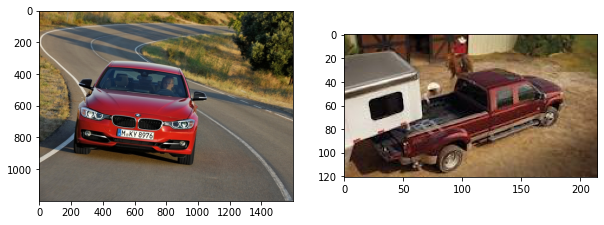

PREDICTION:Rolls-Royce Phantom Sedan 2012, ACTUAL:Rolls-Royce Ghost Sedan 2012
Loss: 5.48, Probability: -0.4021


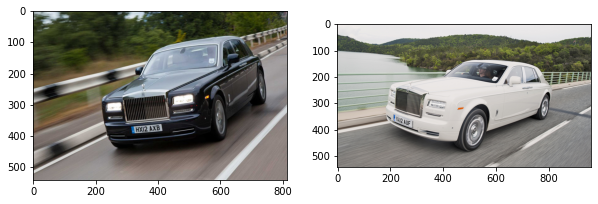

In [40]:
compare_top_losses(10, interp, labels_df, 1, path=path)

# Testiranje na testnom setu podataka

Predikcija na samo jednoj slici iz testnog seta

In [52]:
test_labels_df.head()

,filename,class_name,class_id,vocab_id
0,test_00001.jpg,Suzuki Aerio Sedan 2007,181,180
1,test_00002.jpg,Ferrari 458 Italia Convertible 2012,103,100
2,test_00003.jpg,Jeep Patriot SUV 2012,145,147
3,test_00004.jpg,Toyota Camry Sedan 2012,187,186
4,test_00005.jpg,Tesla Model S Sedan 2012,185,184


In [41]:
test_item = path/'merged'/test_labels_df['filename'][0]; test_item

Path('C:/Users/Morningstar/Documents/CARSv2/merged/test_00001.jpg')

In [42]:
pred_y,pred_idx,probs=learn.predict(test_item)

In [43]:
act_y_id = test_labels_df['vocab_id'][0]
act_y = test_labels_df['class_name'][0]

In [44]:
np.argmax(probs)

tensor(180)

In [45]:
pred_y,act_y

("['smart fortwo Convertible 2012', 'AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura Integra Type R 2001', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'smart fortwo Convertible 2012', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura Integra Type R 2001', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SU

In [46]:
np.argmax(pred_idx),act_y_id

(tensor(180), 180)

Ucitavanje testnih itema na isti nacin kao sto smo ucitavali trening iteme kroz get_x funkciju

In [47]:
test_items = get_x(test_labels_df);test_items

0       C:\Users\Morningstar\Documents\CARSv2\merged\test_00001.jpg
1       C:\Users\Morningstar\Documents\CARSv2\merged\test_00002.jpg
2       C:\Users\Morningstar\Documents\CARSv2\merged\test_00003.jpg
3       C:\Users\Morningstar\Documents\CARSv2\merged\test_00004.jpg
4       C:\Users\Morningstar\Documents\CARSv2\merged\test_00005.jpg
                                   ...                             
8036    C:\Users\Morningstar\Documents\CARSv2\merged\test_08037.jpg
8037    C:\Users\Morningstar\Documents\CARSv2\merged\test_08038.jpg
8038    C:\Users\Morningstar\Documents\CARSv2\merged\test_08039.jpg
8039    C:\Users\Morningstar\Documents\CARSv2\merged\test_08040.jpg
8040    C:\Users\Morningstar\Documents\CARSv2\merged\test_08041.jpg
Name: filename, Length: 8041, dtype: object

Kreiranje test dataloader objekta koji ce sadrzavati sve test iteme

In [48]:
test_dl = learn.dls.test_dl(test_items)

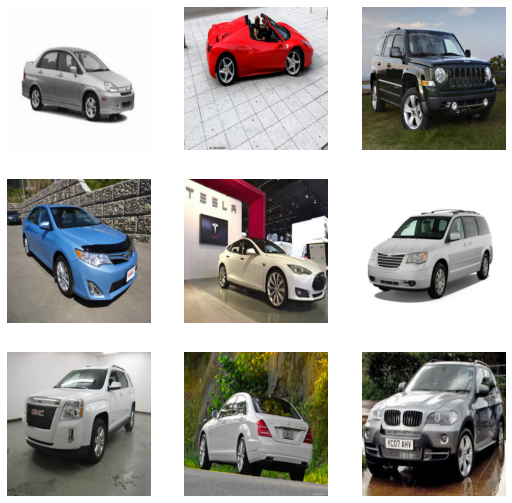

In [65]:
test_dl.show_batch()

Predikcije nad citavim test setom

In [49]:
preds = learn.get_preds(dl=test_dl)

Da bi provjerili tacnost na citavom datasetu prvo trebamo spasiti sve predikcije u jednu varijablu.

Mozemo primjetiti oblik tensora za predikcije, koji je broj slika (8041) sa broj klasa (196), jer za svaku sliku sadrzava 196 vrijednosti koje izgledaju isto kao sto smo vidjeli iznad.

In [50]:
a = preds[0]; a.shape

torch.Size([8041, 196])

Zatim nam treba varijabla, tj tensor s kojim cemo porediti ove predikcije, odnosno onaj koji sadrzava stvarne vrijednosti klasa za slike iz test seta.

Za te potrebe kreirat cemo numpy array koji cemo poslije pretvoriti u PyTorch tensor.

In [51]:
b = np.array(test_labels_df['vocab_id'],dtype=np.int)
b = torch.from_numpy(b);b.shape

torch.Size([8041])

Sve sto nam preostaje je da pozovemo accuracy funkciju koja ce za nas na proslijedenom tensoru a uraditi argmax funkciju i porediti sa proslijedenim tensorom b

In [52]:
accuracy(a,b)

tensor(0.8837)

Tacnost je 88.37 sto znaci da u ovom slucaju skaliranje slika nije poboljsalo rezultate.
Međutim ova tačnost je rezultat puno kraćeg treniranja od prijašnje varijante, odnosno manjeg broja epoha što je dobar rezultat.

Jedna stvar koja je bitna za primjetiti je da je validacijski gubitak (val. loss) manji od trening gubitka (train. loss), sto je direktan rezultat regularizacije koja je sprijecila model da overfittuje na trening set.